In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


In [240]:
# Load data
df = pd.read_csv('master_csv_1.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [ ]:
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.causal_conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.activation = nn.ReLU()
        self.residual_conv = nn.Conv1d(out_channels, in_channels, kernel_size=1)

    def forward(self, x):
        out = self.causal_conv(x)
        out = out[:, :, :-self.causal_conv.padding[0]]  # remove padding for causality
        out = self.activation(out)
        res = self.residual_conv(out)
        return res + x  # residual connection

class IMU2EMG_WaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2):
        super(IMU2EMG_WaveNet, self).__init__()
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        return x


In [ ]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [ ]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask



In [ ]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [247]:
# Create directory for saving models
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
imu_features = 4
model = IMU2EMG_WaveNet(imu_features=imu_features, hidden_channels=64, num_blocks=5, kernel_size=8)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 500

loss_history = []
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for imu_batch, emg_batch, pad_mask in dataloader:
        imu_batch = imu_batch.to(device)
        emg_batch = emg_batch.to(device)
        pad_mask = pad_mask.to(device)

        optimizer.zero_grad()
        outputs = model(imu_batch)

        # Mask padded positions in loss calculation
        outputs_flat = outputs[~pad_mask].view(-1)
        emg_batch_flat = emg_batch[~pad_mask].view(-1)
        loss = criterion(outputs_flat, emg_batch_flat)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

    # Save latest model every epoch
    latest_path = os.path.join(model_dir, 'model_latest.pth')
    torch.save(model.state_dict(), latest_path)

    # Save best model based on loss
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_path = os.path.join(model_dir, 'model_best.pth')
        torch.save(model.state_dict(), best_path)
        print(f"Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")


Epoch [1/500], Loss: 1173.5349
Best model saved at epoch 1 with loss 1173.5349
Epoch [2/500], Loss: 1131.8979
Best model saved at epoch 2 with loss 1131.8979
Epoch [3/500], Loss: 1130.5772
Best model saved at epoch 3 with loss 1130.5772
Epoch [4/500], Loss: 1125.0043
Best model saved at epoch 4 with loss 1125.0043
Epoch [5/500], Loss: 1121.0260
Best model saved at epoch 5 with loss 1121.0260
Epoch [6/500], Loss: 1121.3055
Epoch [7/500], Loss: 1122.7106
Epoch [8/500], Loss: 1122.2438
Epoch [9/500], Loss: 1124.5873
Epoch [10/500], Loss: 1125.2555
Epoch [11/500], Loss: 1129.9392
Epoch [12/500], Loss: 1121.4114
Epoch [13/500], Loss: 1125.6640
Epoch [14/500], Loss: 1120.3616
Best model saved at epoch 14 with loss 1120.3616
Epoch [15/500], Loss: 1129.0507
Epoch [16/500], Loss: 1127.6037
Epoch [17/500], Loss: 1117.1223
Best model saved at epoch 17 with loss 1117.1223
Epoch [18/500], Loss: 1123.0017
Epoch [19/500], Loss: 1121.8718
Epoch [20/500], Loss: 1123.6865
Epoch [21/500], Loss: 1127.8147

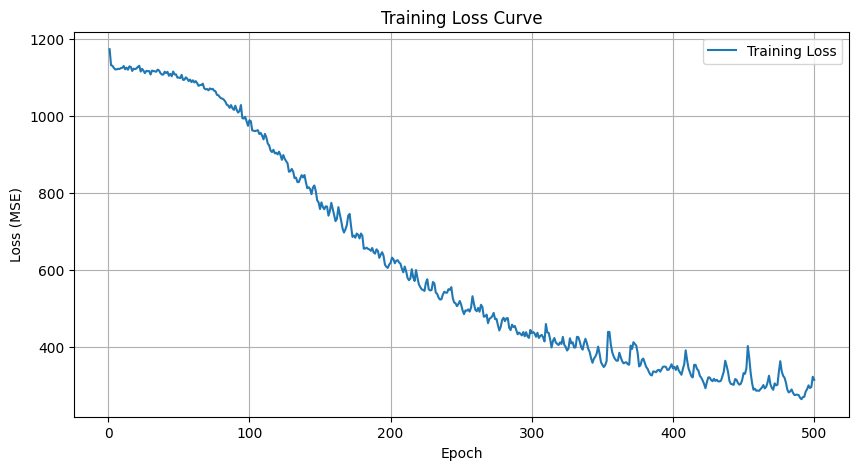

In [248]:
# After training, plot the loss curve
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [252]:
min(loss_history)

264.84039306640625

In [255]:
# Assuming you have one segment's IMU data:
imu_segment_test = imu_segments[123]  # shape: (seq_len, imu_features)

# Convert to tensor
imu_tensor = torch.tensor(imu_segment_test, dtype=torch.float32)

# Add batch dimension
imu_tensor = imu_tensor.unsqueeze(0)  # shape: (1, seq_len, imu_features)

# Model in eval mode
model.eval()
with torch.no_grad():
    predicted_emg = model(imu_tensor)  # shape: (1, seq_len, 1)

# Remove batch dimension
predicted_emg = predicted_emg.squeeze(0).squeeze(-1).numpy()  # shape: (seq_len,)


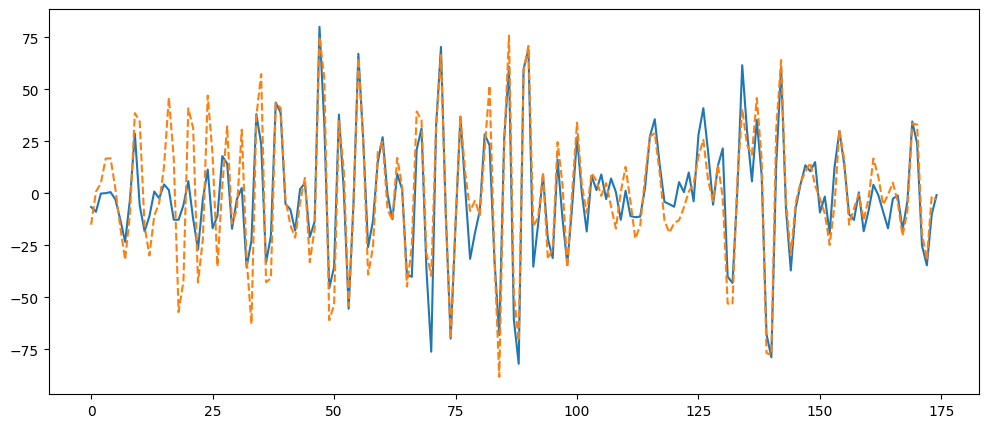

In [256]:
plt.figure(figsize=(12, 5))
plt.plot(predicted_emg)
plt.plot(emg_segments[123], linestyle='--')
plt.show()